Importing necessary libraries

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller

RoBERTa Sentiment Analysis

In [2]:
df = pd.read_csv('/teamspace/studios/this_studio/spotify_reviews.csv')

text_column = 'content'  

# Load fine-tuned RoBERTa model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Creating pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

# define function to get sentiment scores
def get_sentiment_scores(texts, batch_size=16):
    """
    Process texts in batches to get sentiment scores.
    Returns a list of dictionaries with labels and scores.
    """
    results = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_texts = [str(text) if pd.notnull(text) else "" for text in batch_texts]
        batch_results = sentiment_pipeline(batch_texts, truncation=True, max_length=512)
        results.extend(batch_results)
    return results


texts = df[text_column].tolist()
sentiment_results = get_sentiment_scores(texts)

df['Sentiment_Label'] = [result['label'].replace('LABEL_0', 'NEGATIVE').replace('LABEL_1', 'NEUTRAL').replace('LABEL_2', 'POSITIVE') for result in sentiment_results]
df['Sentiment_Score'] = [result['score'] for result in sentiment_results]

sentiment_mapping = {'NEGATIVE': -1, 'NEUTRAL': 0, 'POSITIVE': 1}
df['Sentiment_Numeric'] = df['Sentiment_Label'].map(sentiment_mapping)

output_path = '/teamspace/studios/this_studio/spotify_reviews_with_sentiment.csv'
df.to_csv(output_path, index=False)

print("Sample results:")
print(df[[text_column, 'Sentiment_Label', 'Sentiment_Score', 'Sentiment_Numeric']].head())

print("\nSentiment distribution:")
print(df['Sentiment_Label'].value_counts())

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cpu


Sample results:
                                             content Sentiment_Label  \
0                                          It's good        POSITIVE   
1  I love this app so much, I've been using Spoti...        NEGATIVE   
2                                            Perfect        POSITIVE   
3  Best all around music streaming app I have use...        POSITIVE   
4  Are y'all fr gatekeeping the play button on so...         NEUTRAL   

   Sentiment_Score  Sentiment_Numeric  
0         0.960607                  1  
1         0.785313                 -1  
2         0.649363                  1  
3         0.991726                  1  
4         0.765609                  0  

Sentiment distribution:
Sentiment_Label
NEGATIVE    57321
POSITIVE    21496
NEUTRAL      5348
Name: count, dtype: int64


Storing RoBERTa generated sentiments in a file

In [11]:
df = pd.read_csv('/teamspace/studios/this_studio/spotify_reviews_with_sentiment.csv')

Checking samples

In [12]:
df[['reviewId', 'content', 'score', 'at', 'Sentiment_Label']].head()

,reviewId,content,score,at,Sentiment_Label
0,437314fe-1b1d-4352-abea-12fec30fce58,It's good,4,2024-05-09 16:28:13,POSITIVE
1,4933ad2c-c70a-4a84-957d-d405439b2e0f,"I love this app so much, I've been using Spoti...",5,2024-05-09 16:27:18,NEGATIVE
2,1ab275fb-59bf-42c7-88ef-b85901f0445e,Perfect,5,2024-05-09 16:27:03,POSITIVE
3,b38406eb-7b11-4ceb-a45c-d7f28fb5d382,Best all around music streaming app I have use...,5,2024-05-09 16:26:19,POSITIVE
4,7be7999d-4cb6-47b9-8414-d7bdaa9df578,Are y'all fr gatekeeping the play button on so...,1,2024-05-09 16:26:14,NEUTRAL


In [14]:
# Data Preprocessing
df = pd.read_csv('spotify_reviews_with_sentiment.csv')
df['at'] = pd.to_datetime(df['at'])  # Ensure timestamp is datetime

# Scale Sentiment_Numeric from [-1, 1] to [0, 1]
df['Sentiment_Numeric_Scaled'] = (df['Sentiment_Numeric'] + 1) / 2

# 12-hour aggregation using scaled values
time_series = df.groupby(pd.Grouper(key='at', freq='12H'))['Sentiment_Numeric_Scaled'].mean().dropna()

# Check for sparse intervals
avg_reviews = df.groupby(pd.Grouper(key='at', freq='12H')).size().mean()
print(f"\nNumber of 12-hour intervals: {len(time_series)}")
print(f"Average reviews per interval: {avg_reviews:.2f}")
if avg_reviews < 5:
    print("Warning: Sparse intervals detected. Applying forward fill.")
    time_series = time_series.fillna(method='ffill')


Number of 12-hour intervals: 4134
Average reviews per interval: 20.36


ADF test

In [33]:
differenced = False

# Perform ADF test on the time_series
print("\nRunning Augmented Dickey-Fuller (ADF) Test on time_series...")
adf_result = adfuller(time_series)

# Extract and display results
adf_statistic = adf_result[0]
p_value = adf_result[1]
critical_values = adf_result[4]

print(f"ADF Statistic: {adf_statistic:.4f}")
print(f"p-value: {p_value:.4f}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"  {key}: {value:.4f}")

# Interpret the result
if p_value < 0.05:
    print("Result: p-value < 0.05. Reject the null hypothesis. The time series is stationary.")
else:
    print("Result: p-value >= 0.05. Fail to reject the null hypothesis. The time series is non-stationary.")
    print("Applying first-order differencing to make the series stationary...")
    # Apply first-order differencing
    time_series_diff = time_series.diff().dropna()
    # Re-run ADF test on the differenced series
    print("\nRunning ADF Test on differenced time_series...")
    adf_result_diff = adfuller(time_series_diff)
    
    adf_statistic_diff = adf_result_diff[0]
    p_value_diff = adf_result_diff[1]
    critical_values_diff = adf_result_diff[4]
    
    print(f"ADF Statistic (differenced): {adf_statistic_diff:.4f}")
    print(f"p-value (differenced): {p_value_diff:.4f}")
    print("Critical Values (differenced):")
    for key, value in critical_values_diff.items():
        print(f"  {key}: {value:.4f}")
    
    if p_value_diff < 0.05:
        print("Result: p-value < 0.05. The differenced time series is stationary.")
        # Update time_series to use the differenced data
        time_series = time_series_diff
        differenced = True
        print("Proceeding with the differenced time series for modeling.")
    else:
        print("Result: p-value >= 0.05. The differenced time series is still non-stationary.")
        print("Further differencing or other transformations may be required. Proceeding with original time_series for now.")


Running Augmented Dickey-Fuller (ADF) Test on time_series...
ADF Statistic: -6.5119
p-value: 0.0000
Critical Values:
  1%: -3.4319
  5%: -2.8622
  10%: -2.5671
Result: p-value < 0.05. Reject the null hypothesis. The time series is stationary.


In [15]:
# Scaling time series for model input
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(time_series.values.reshape(-1, 1)).flatten()

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10  
X, y = create_sequences(data_scaled, seq_length)

# Train/Val/Test split (70/15/15)
N = len(X)
train_end = int(0.7 * N)
val_end = int(0.85 * N)
X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

Define Models

BiLSTM

In [16]:
class BiLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=4):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                            batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        output, _ = self.lstm(x)
        return self.fc(output[:, -1, :]).squeeze()

Transformer

In [17]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

# Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_size=1, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0):
        super(TransformerModel, self).__init__()
        self.input_size = input_size
        self.d_model = d_model
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.fc(x[:, -1, :])
        return x.squeeze(-1)

N-BEATS

In [18]:
class NBEATSBlock(nn.Module):
    def __init__(self, input_size, hidden_size, theta_size):
        super(NBEATSBlock, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, theta_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        theta = self.fc4(x)
        return theta

class NBEATSModel(nn.Module):
    def __init__(self, input_size=10, hidden_size=512, num_blocks=3, theta_size=64):
        super(NBEATSModel, self).__init__()
        self.input_size = input_size
        self.blocks = nn.ModuleList([NBEATSBlock(input_size, hidden_size, theta_size) for _ in range(num_blocks)])
        self.forecast_layer = nn.Linear(theta_size, 1)

    def forward(self, x):
        forecast = 0
        for block in self.blocks:
            theta = block(x)
            forecast = forecast + self.forecast_layer(theta)
        return forecast.squeeze(-1)

TCN

In [19]:
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(TCNBlock, self).__init__()
        self.conv = nn.Conv1d(
            in_channels, out_channels, kernel_size,
            padding=(kernel_size-1) * dilation, dilation=dilation
        )
        self.batch_norm = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        out = self.conv(x)
        out = out[:, :, :x.size(2)]  
        out = F.relu(out)
        out = self.batch_norm(out)
        out = self.dropout(out)
        return out

class TCNModel(nn.Module):
    def __init__(self, input_size=1, num_channels=64, kernel_size=3, dilations=[1, 2, 4, 8, 16], seq_length=10):
        super(TCNModel, self).__init__()
        self.input_size = input_size
        self.seq_length = seq_length
        layers = []
        in_channels = input_size
        for dilation in dilations:
            layers.append(TCNBlock(in_channels, num_channels, kernel_size, dilation))
            in_channels = num_channels
        self.tcn = nn.Sequential(*layers)
        self.fc = nn.Linear(num_channels * seq_length, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  
        out = self.tcn(x)  
        out = out.view(out.size(0), -1)  
        out = self.fc(out)  
        return out.squeeze(-1)

Traininf Function

In [21]:
def train_model(X_train, y_train, X_val, y_val, X_test, y_test, model_class, sequence_length=10, hidden_size=256, 
                num_layers=4, epochs=20, batch_size=32, lr=0.001, model_name='Model', scaler=None, patience=10):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if model_class == NBEATSModel:
        
        X_train_input = torch.FloatTensor(X_train)
        X_val_input = torch.FloatTensor(X_val)
        X_test_input = torch.FloatTensor(X_test)
        model = model_class(input_size=sequence_length, hidden_size=512, num_blocks=3, theta_size=64).to(device)
    else:
        
        X_train_input = torch.FloatTensor(X_train).unsqueeze(-1)  
        X_val_input = torch.FloatTensor(X_val).unsqueeze(-1)
        X_test_input = torch.FloatTensor(X_test).unsqueeze(-1)
        if model_class == TransformerModel:
            model = model_class(input_size=1, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1).to(device)
        elif model_class == TCNModel:
            model = model_class(input_size=1, num_channels=64, kernel_size=3, dilations=[1, 2, 4, 8, 16], seq_length=sequence_length).to(device)
        else:
            model = model_class(input_size=1, hidden_size=hidden_size, num_layers=num_layers).to(device)

    # Prepare datasets
    train_dataset = TensorDataset(X_train_input, torch.FloatTensor(y_train))
    val_dataset = TensorDataset(X_val_input, torch.FloatTensor(y_val))
    test_dataset = TensorDataset(X_test_input, torch.FloatTensor(y_test))
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, verbose=True)

    # Early stopping 
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    early_stop_epoch = epochs

    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss = train_loss / len(train_loader)

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_input = X_val_input.to(device)
            val_pred = model(val_input)
            val_loss = criterion(val_pred.squeeze(), torch.FloatTensor(y_val).to(device))

        scheduler.step(val_loss)

        # Early stopping logic
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}. Best validation loss: {best_val_loss:.4f}")
                early_stop_epoch = epoch + 1
                break

        print(f"[{model_name}] Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss.item():.4f}")

 

    # Evaluate on test set
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            output = model(X_batch).cpu().numpy().flatten()
            predictions.extend(output)
            actuals.extend(y_batch.numpy().flatten())

    # Inverse scale
    y_test_inv = scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()
    y_pred_inv = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

    # Metrics
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    print(f"[{model_name}] MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    return y_test_inv, y_pred_inv, mse, mae, rmse, early_stop_epoch

Training Models

In [ ]:
bilstm_results = train_model(X_train, y_train, X_val, y_val, X_test, y_test, BiLSTM, model_name='BiLSTM', scaler=scaler, patience=10)
transformer_results = train_model(X_train, y_train, X_val, y_val, X_test, y_test, TransformerModel, model_name='Transformer', scaler=scaler, patience=10)
nbeats_results = train_model(X_train, y_train, X_val, y_val, X_test, y_test, NBEATSModel, model_name='N-BEATS', scaler=scaler, patience=10)
tcn_results = train_model(X_train, y_train, X_val, y_val, X_test, y_test, TCNModel, model_name='TCN', scaler=scaler, patience=10)

y_test_inv_bilstm, y_pred_inv_bilstm, bilstm_mse, bilstm_mae, bilstm_rmse, bilstm_stop_epoch = bilstm_results
y_test_inv_transformer, y_pred_inv_transformer, transformer_mse, transformer_mae, transformer_rmse, transformer_stop_epoch = transformer_results
y_test_inv_nbeats, y_pred_inv_nbeats, nbeats_mse, nbeats_mae, nbeats_rmse, nbeats_stop_epoch = nbeats_results
y_test_inv_tcn, y_pred_inv_tcn, tcn_mse, tcn_mae, tcn_rmse, tcn_stop_epoch = tcn_results

# Moving Average
ma_pred = np.array([np.mean(X_test[i, :]) for i in range(X_test.shape[0])])
ma_pred_inv = scaler.inverse_transform(ma_pred.reshape(-1, 1)).flatten()
ma_mse = mean_squared_error(y_test_inv_bilstm, ma_pred_inv)
ma_mae = mean_absolute_error(y_test_inv_bilstm, ma_pred_inv)
ma_rmse = np.sqrt(ma_mse)
print(f"[Moving Average] MSE: {ma_mse:.4f}, MAE: {ma_mae:.4f}, RMSE: {ma_rmse:.4f}")




Number of 12-hour intervals: 4134
Average reviews per interval: 20.36


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[BiLSTM] Epoch 1/20, Train Loss: 0.1088, Val Loss: 0.0931
[BiLSTM] Epoch 2/20, Train Loss: 0.0994, Val Loss: 0.0960
[BiLSTM] Epoch 3/20, Train Loss: 0.1025, Val Loss: 0.0934
[BiLSTM] Epoch 4/20, Train Loss: 0.1013, Val Loss: 0.0961
[BiLSTM] Epoch 5/20, Train Loss: 0.0995, Val Loss: 0.0920
[BiLSTM] Epoch 6/20, Train Loss: 0.0997, Val Loss: 0.0934
[BiLSTM] Epoch 7/20, Train Loss: 0.1003, Val Loss: 0.0934
[BiLSTM] Epoch 8/20, Train Loss: 0.0993, Val Loss: 0.0918
[BiLSTM] Epoch 9/20, Train Loss: 0.0999, Val Loss: 0.0917
[BiLSTM] Epoch 10/20, Train Loss: 0.1000, Val Loss: 0.0930
[BiLSTM] Epoch 11/20, Train Loss: 0.0987, Val Loss: 0.0930
[BiLSTM] Epoch 12/20, Train Loss: 0.0985, Val Loss: 0.0941
[BiLSTM] Epoch 13/20, Train Loss: 0.0986, Val Loss: 0.0908
[BiLSTM] Epoch 14/20, Train Loss: 0.1025, Val Loss: 0.1049
[BiLSTM] Epoch 15/20, Train Loss: 0.1001, Val Loss: 0.0933
[BiLSTM] Epoch 16/20, Train Loss: 0.0983, Val Loss: 0.0902
[BiLSTM] Epoch 17/20, Train Loss: 0.0990, Val Loss: 0.0919
[BiLST

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[Transformer] Epoch 1/20, Train Loss: 0.1229, Val Loss: 0.0910
[Transformer] Epoch 2/20, Train Loss: 0.1061, Val Loss: 0.0953
[Transformer] Epoch 3/20, Train Loss: 0.1051, Val Loss: 0.0923
[Transformer] Epoch 4/20, Train Loss: 0.1007, Val Loss: 0.0905
[Transformer] Epoch 5/20, Train Loss: 0.1000, Val Loss: 0.0999
[Transformer] Epoch 6/20, Train Loss: 0.1010, Val Loss: 0.0922
[Transformer] Epoch 7/20, Train Loss: 0.1004, Val Loss: 0.0925
[Transformer] Epoch 8/20, Train Loss: 0.0999, Val Loss: 0.0901
[Transformer] Epoch 9/20, Train Loss: 0.1006, Val Loss: 0.0904
[Transformer] Epoch 10/20, Train Loss: 0.1029, Val Loss: 0.0931
[Transformer] Epoch 11/20, Train Loss: 0.1014, Val Loss: 0.0923
[Transformer] Epoch 12/20, Train Loss: 0.0992, Val Loss: 0.0904
[Transformer] Epoch 13/20, Train Loss: 0.0971, Val Loss: 0.0930
[Transformer] Epoch 14/20, Train Loss: 0.0980, Val Loss: 0.0905
[Transformer] Epoch 15/20, Train Loss: 0.0983, Val Loss: 0.0910
[Transformer] Epoch 16/20, Train Loss: 0.0981, Va

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[N-BEATS] Epoch 1/20, Train Loss: 0.1061, Val Loss: 0.0914
[N-BEATS] Epoch 2/20, Train Loss: 0.1003, Val Loss: 0.0922
[N-BEATS] Epoch 3/20, Train Loss: 0.0985, Val Loss: 0.0935
[N-BEATS] Epoch 4/20, Train Loss: 0.0987, Val Loss: 0.1072
[N-BEATS] Epoch 5/20, Train Loss: 0.0954, Val Loss: 0.0947
[N-BEATS] Epoch 6/20, Train Loss: 0.0915, Val Loss: 0.0941
[N-BEATS] Epoch 7/20, Train Loss: 0.0893, Val Loss: 0.0929
[N-BEATS] Epoch 8/20, Train Loss: 0.0890, Val Loss: 0.1031
[N-BEATS] Epoch 9/20, Train Loss: 0.0865, Val Loss: 0.0950
[N-BEATS] Epoch 10/20, Train Loss: 0.0811, Val Loss: 0.0961
Early stopping triggered at epoch 11. Best validation loss: 0.0914
[N-BEATS] MSE: 0.0069, MAE: 0.0629, RMSE: 0.0832


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[TCN] Epoch 1/20, Train Loss: 0.2627, Val Loss: 0.1250
[TCN] Epoch 2/20, Train Loss: 0.1529, Val Loss: 0.1143
[TCN] Epoch 3/20, Train Loss: 0.1262, Val Loss: 0.1015
[TCN] Epoch 4/20, Train Loss: 0.1114, Val Loss: 0.1085
[TCN] Epoch 5/20, Train Loss: 0.1157, Val Loss: 0.1050
[TCN] Epoch 6/20, Train Loss: 0.1128, Val Loss: 0.1019
[TCN] Epoch 7/20, Train Loss: 0.1066, Val Loss: 0.1067
[TCN] Epoch 8/20, Train Loss: 0.1035, Val Loss: 0.0929
[TCN] Epoch 9/20, Train Loss: 0.1020, Val Loss: 0.0968
[TCN] Epoch 10/20, Train Loss: 0.0990, Val Loss: 0.0986
[TCN] Epoch 11/20, Train Loss: 0.1000, Val Loss: 0.0993
[TCN] Epoch 12/20, Train Loss: 0.0987, Val Loss: 0.0994
[TCN] Epoch 13/20, Train Loss: 0.0945, Val Loss: 0.0959
[TCN] Epoch 14/20, Train Loss: 0.0951, Val Loss: 0.0940
[TCN] Epoch 15/20, Train Loss: 0.0922, Val Loss: 0.0956
[TCN] Epoch 16/20, Train Loss: 0.0925, Val Loss: 0.0940
[TCN] Epoch 17/20, Train Loss: 0.0936, Val Loss: 0.0937
Early stopping triggered at epoch 18. Best validation los

Graphs for Test Set

BiLSTM

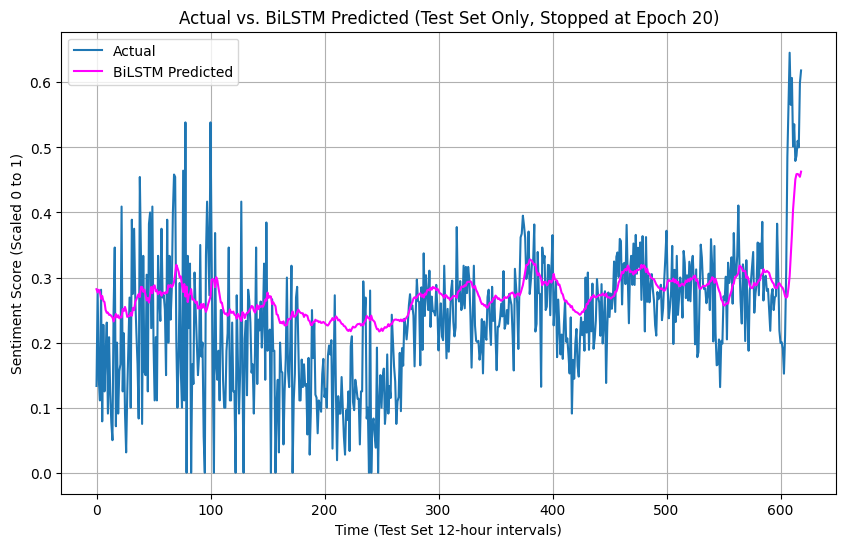

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv_bilstm, label='Actual')
plt.plot(y_pred_inv_bilstm, label='BiLSTM Predicted', color='magenta')
plt.xlabel('Time (Test Set 12-hour intervals)')
plt.ylabel('Sentiment Score (Scaled 0 to 1)')
plt.title(f'Actual vs. BiLSTM Predicted (Test Set Only, Stopped at Epoch {bilstm_stop_epoch})')
plt.legend()
plt.grid(True)
plt.savefig('bilstm_plot.png')
plt.show()

Transformer

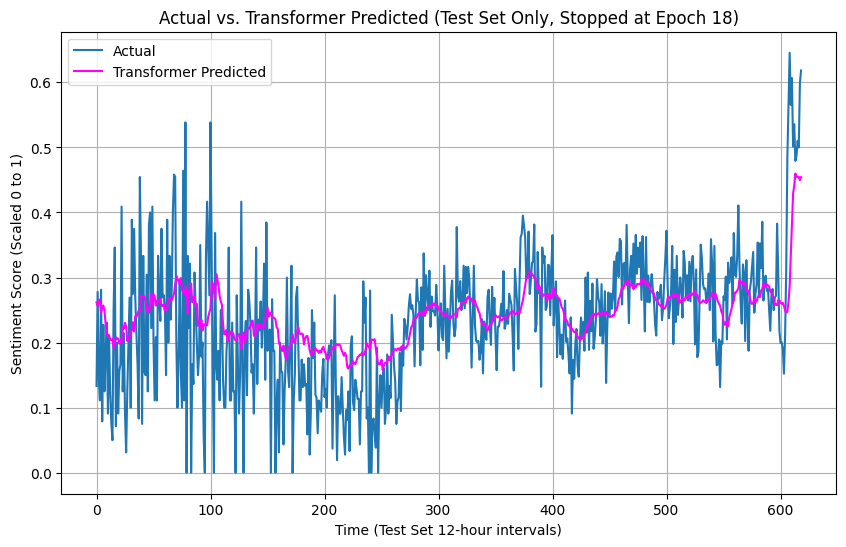

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv_transformer, label='Actual')
plt.plot(y_pred_inv_transformer, label='Transformer Predicted', color='magenta')
plt.xlabel('Time (Test Set 12-hour intervals)')
plt.ylabel('Sentiment Score (Scaled 0 to 1)')
plt.title(f'Actual vs. Transformer Predicted (Test Set Only, Stopped at Epoch {transformer_stop_epoch})')
plt.legend()
plt.grid(True)
plt.savefig('transformer_plot.png')
plt.show()

N-BEATS

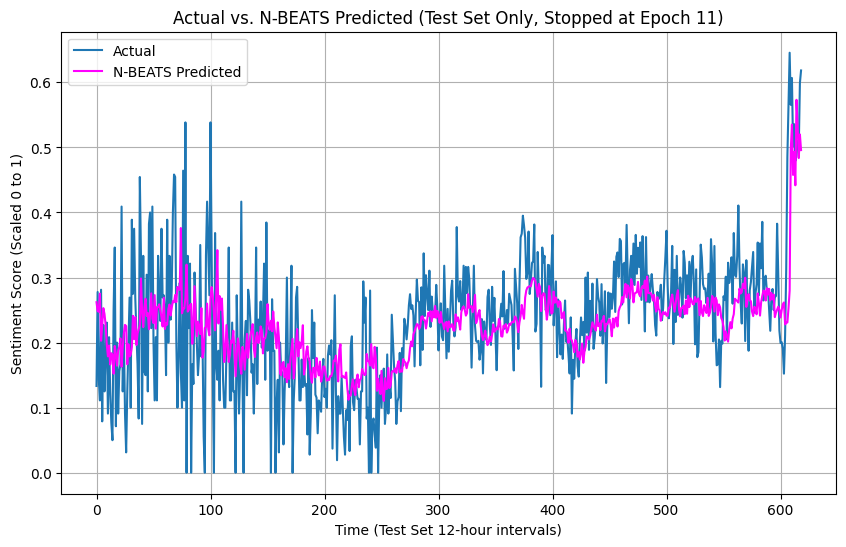

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv_nbeats, label='Actual')
plt.plot(y_pred_inv_nbeats, label='N-BEATS Predicted', color='magenta')
plt.xlabel('Time (Test Set 12-hour intervals)')
plt.ylabel('Sentiment Score (Scaled 0 to 1)')
plt.title(f'Actual vs. N-BEATS Predicted (Test Set Only, Stopped at Epoch {nbeats_stop_epoch})')
plt.legend()
plt.grid(True)
plt.savefig('nbeats_plot.png')
plt.show()

TCN

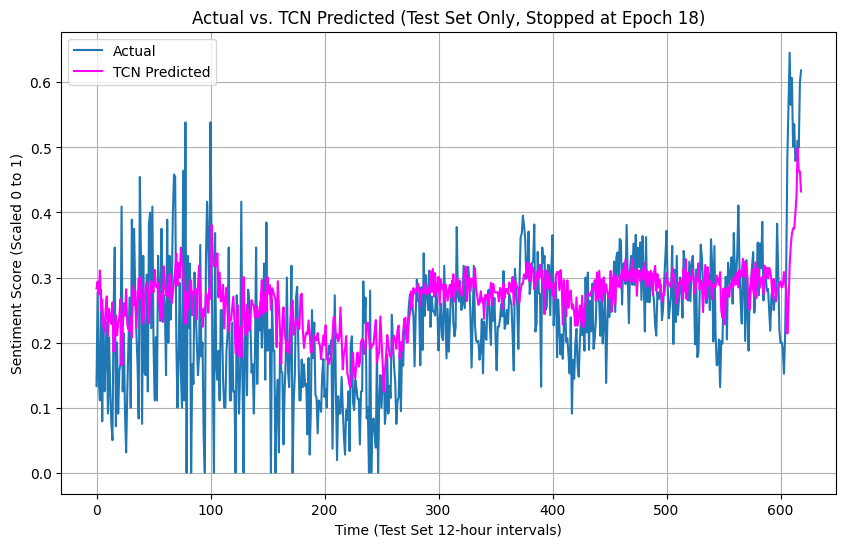

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv_tcn, label='Actual')
plt.plot(y_pred_inv_tcn, label='TCN Predicted', color='magenta')
plt.xlabel('Time (Test Set 12-hour intervals)')
plt.ylabel('Sentiment Score (Scaled 0 to 1)')
plt.title(f'Actual vs. TCN Predicted (Test Set Only, Stopped at Epoch {tcn_stop_epoch})')
plt.legend()
plt.grid(True)
plt.savefig('tcn_plot.png')
plt.show()

Moving Average

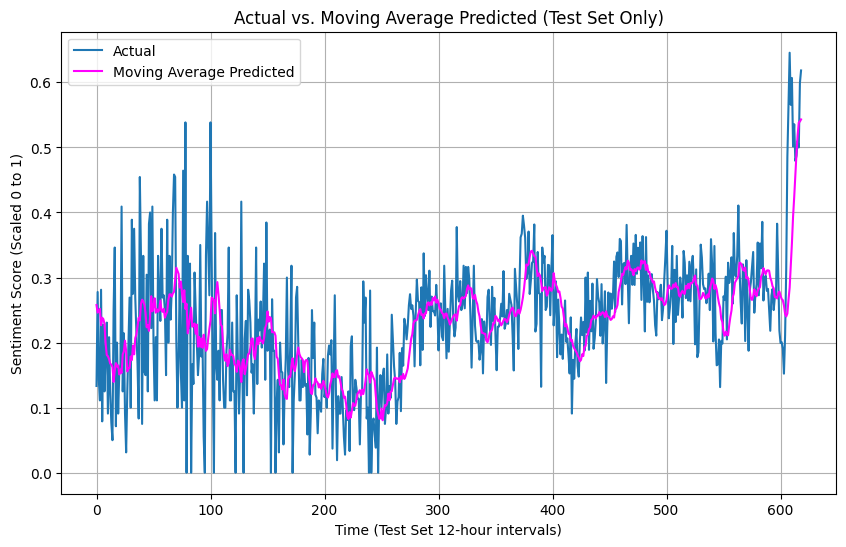

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv_bilstm, label='Actual')
plt.plot(ma_pred_inv, label='Moving Average Predicted', color='magenta')
plt.xlabel('Time (Test Set 12-hour intervals)')
plt.ylabel('Sentiment Score (Scaled 0 to 1)')
plt.title('Actual vs. Moving Average Predicted (Test Set Only)')
plt.legend()
plt.grid(True)
plt.savefig('ma_plot.png')
plt.show()

Combined Plots

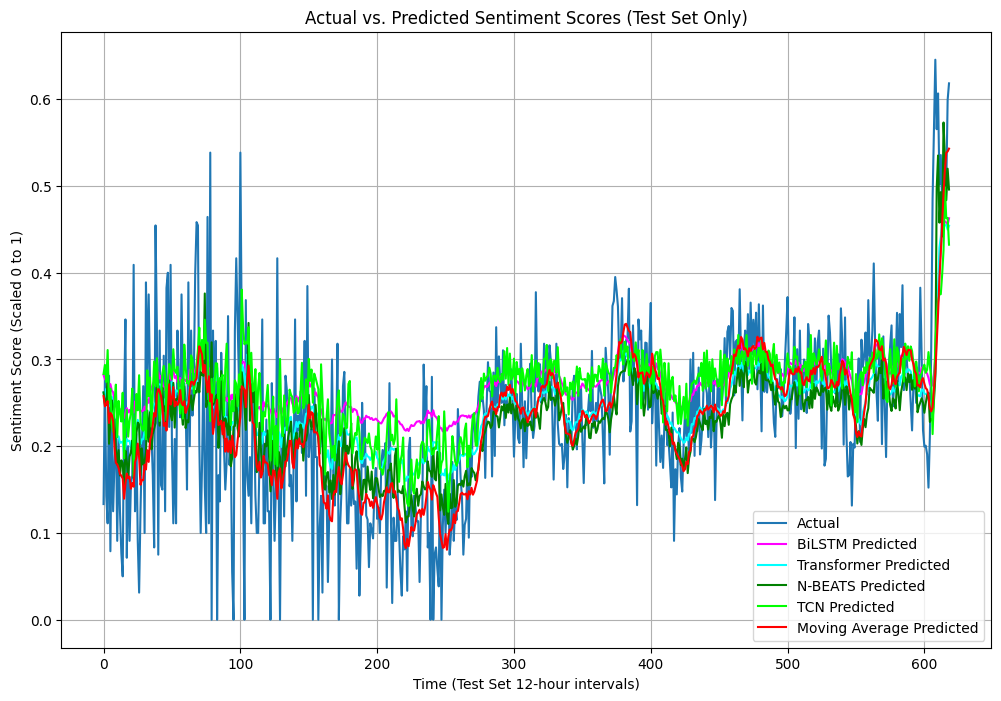

In [27]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_inv_bilstm, label='Actual')
plt.plot(y_pred_inv_bilstm, label='BiLSTM Predicted', color='magenta')
plt.plot(y_pred_inv_transformer, label='Transformer Predicted', color='cyan')
plt.plot(y_pred_inv_nbeats, label='N-BEATS Predicted', color='green')
plt.plot(y_pred_inv_tcn, label='TCN Predicted', color='lime')
plt.plot(ma_pred_inv, label='Moving Average Predicted', color='red')
plt.xlabel('Time (Test Set 12-hour intervals)')
plt.ylabel('Sentiment Score (Scaled 0 to 1)')
plt.title('Actual vs. Predicted Sentiment Scores (Test Set Only)')
plt.legend()
plt.grid(True)
plt.savefig('combined_plot.png')
plt.show()

Comparison Table

In [28]:
print("\nPerformance Comparison:")
print(f"{'Model':<25} | {'MSE':<8} | {'MAE':<8} | {'RMSE':<8}")
print("-" * 72)
print(f"{'BiLSTM':<25} | {bilstm_mse:.4f} | {bilstm_mae:.4f} | {bilstm_rmse:.4f}")
print(f"{'Transformer':<25} | {transformer_mse:.4f} | {transformer_mae:.4f} | {transformer_rmse:.4f}")
print(f"{'N-BEATS':<25} | {nbeats_mse:.4f} | {nbeats_mae:.4f} | {nbeats_rmse:.4f}")
print(f"{'TCN':<25} | {tcn_mse:.4f} | {tcn_mae:.4f} | {tcn_rmse:.4f}")
print(f"{'Moving Average':<25} | {ma_mse:.4f} | {ma_mae:.4f} | {ma_rmse:.4f}")


Performance Comparison:
Model                     | MSE      | MAE      | RMSE    
------------------------------------------------------------------------
BiLSTM                    | 0.0090 | 0.0728 | 0.0946
Transformer               | 0.0073 | 0.0642 | 0.0852
N-BEATS                   | 0.0069 | 0.0629 | 0.0832
TCN                       | 0.0088 | 0.0713 | 0.0937
Moving Average            | 0.0067 | 0.0608 | 0.0821


Saving Forecasts

In [29]:
pd.DataFrame({
    'Actual': y_test_inv_bilstm,
    'BiLSTM': y_pred_inv_bilstm,
    'Transformer': y_pred_inv_transformer,
    'N-BEATS': y_pred_inv_nbeats,
    'TCN': y_pred_inv_tcn,
    'Moving Average': ma_pred_inv
}).to_csv('forecasts_12h_sequential.csv')

 Generate Training Data Summary Tables (Preview and Summary Statistics) 

In [ ]:
review_counts = df.groupby(pd.Grouper(key='at', freq='12H')).size()
review_counts = review_counts.reindex(time_series.index, fill_value=0)
train_time_steps = train_end + seq_length
train_indices = time_series.index[:train_time_steps]
train_timestamps = train_indices
train_review_counts = review_counts.loc[train_indices]
train_avg_sentiment_scaled = time_series.loc[train_indices]

training_data_table = pd.DataFrame({
    'Timestamp': train_timestamps,
    'Review Count': train_review_counts,
    'Avg Sentiment (Scaled 0 to 1)': train_avg_sentiment_scaled
})
training_data_table = training_data_table.reset_index(drop=True)
training_data_table['Avg Sentiment (Scaled 0 to 1)'] = training_data_table['Avg Sentiment (Scaled 0 to 1)'].round(4)
preview_table = training_data_table.head(5)

print("\nTraining Data Preview Table (First 5 Intervals):")
print(preview_table)

summary_table = pd.DataFrame({
    'Metric': [
        'Total Intervals',
        'Avg Review Count',
        'Min Review Count',
        'Max Review Count',
        'Avg Sentiment (Scaled 0 to 1)',
        'Min Sentiment (Scaled 0 to 1)',
        'Max Sentiment (Scaled 0 to 1)'
    ],
    'Value': [
        len(train_timestamps),
        train_review_counts.mean(),
        train_review_counts.min(),
        train_review_counts.max(),
        train_avg_sentiment_scaled.mean(),
        train_avg_sentiment_scaled.min(),
        train_avg_sentiment_scaled.max()
    ]
})
summary_table['Value'] = summary_table['Value'].round(4)
print("\nTraining Data Summary Statistics:")
print(summary_table)



Training Data Preview Table (First 5 Intervals):
            Timestamp  Review Count  Avg Sentiment (Scaled 0 to 1)
0 2018-09-12 00:00:00             2                         0.5000
1 2018-09-12 12:00:00             2                         0.2500
2 2018-09-13 00:00:00             6                         0.1667
3 2018-09-13 12:00:00             5                         0.0000
4 2018-09-14 00:00:00             5                         0.1000

Training Data Summary Statistics:
                          Metric      Value
0                Total Intervals  2896.0000
1               Avg Review Count    12.3450
2               Min Review Count     1.0000
3               Max Review Count    92.0000
4  Avg Sentiment (Scaled 0 to 1)     0.3026
5  Min Sentiment (Scaled 0 to 1)     0.0000
6  Max Sentiment (Scaled 0 to 1)     1.0000


Generate Test Data Summary Tables (Preview and Summary Statistics)

In [31]:
test_start_idx = val_end
test_end_idx = val_end + len(X_test) + seq_length  
test_indices = time_series.index[test_start_idx:test_end_idx]
test_timestamps = test_indices
test_review_counts = review_counts.loc[test_indices]
test_avg_sentiment_scaled = time_series.loc[test_indices]

test_data_table = pd.DataFrame({
    'Timestamp': test_timestamps,
    'Review Count': test_review_counts,
    'Avg Sentiment (Scaled 0 to 1)': test_avg_sentiment_scaled
})

test_data_table = test_data_table.reset_index(drop=True)

test_data_table['Avg Sentiment (Scaled 0 to 1)'] = test_data_table['Avg Sentiment (Scaled 0 to 1)'].round(4)

test_preview_table = test_data_table.head(5)

print("\nTest Data Preview Table (First 5 Intervals):")
print(test_preview_table)

test_summary_table = pd.DataFrame({
    'Metric': [
        'Total Intervals',
        'Avg Review Count',
        'Min Review Count',
        'Max Review Count',
        'Avg Sentiment (Scaled 0 to 1)',
        'Min Sentiment (Scaled 0 to 1)',
        'Max Sentiment (Scaled 0 to 1)'
    ],
    'Value': [
        len(test_timestamps),
        test_review_counts.mean(),
        test_review_counts.min(),
        test_review_counts.max(),
        test_avg_sentiment_scaled.mean(),
        test_avg_sentiment_scaled.min(),
        test_avg_sentiment_scaled.max()
    ]
})
test_summary_table['Value'] = test_summary_table['Value'].round(4)

print("\nTest Data Summary Statistics:")
print(test_summary_table)


Test Data Preview Table (First 5 Intervals):
            Timestamp  Review Count  Avg Sentiment (Scaled 0 to 1)
0 2023-06-30 12:00:00            10                         0.2500
1 2023-07-01 00:00:00             4                         0.2500
2 2023-07-01 12:00:00             9                         0.1111
3 2023-07-02 00:00:00            11                         0.3636
4 2023-07-02 12:00:00            18                         0.1667

Test Data Summary Statistics:
                          Metric     Value
0                Total Intervals  629.0000
1               Avg Review Count   65.7933
2               Min Review Count    3.0000
3               Max Review Count  772.0000
4  Avg Sentiment (Scaled 0 to 1)    0.2340
5  Min Sentiment (Scaled 0 to 1)    0.0000
6  Max Sentiment (Scaled 0 to 1)    0.6455
